In [ ]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories") 

In [57]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

In [58]:
enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

In [59]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [61]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [62]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [63]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 20000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [64]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_5611/2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [65]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  2%|▎         | 500/20000 [00:53<33:51,  9.60it/s] 

Epoch 500: train loss 9.4174, val loss 9.4261
The current learning rate: 0.00007


  5%|▌         | 1000/20000 [02:45<29:27, 10.75it/s]  

Epoch 1000: train loss 8.4870, val loss 8.4928
The current learning rate: 0.00010


  7%|▋         | 1499/20000 [04:41<36:00,  8.56it/s]   

Epoch 1500: train loss 7.5308, val loss 7.5339
The current learning rate: 0.00010


 10%|█         | 2000/20000 [06:35<27:53, 10.76it/s]   

Epoch 2000: train loss 6.6740, val loss 6.6757
The current learning rate: 0.00010


 12%|█▏        | 2499/20000 [08:00<27:22, 10.65it/s]   

Epoch 2500: train loss 5.9826, val loss 5.9841
The current learning rate: 0.00011


 15%|█▍        | 2999/20000 [09:30<26:24, 10.73it/s]   

Epoch 3000: train loss 5.4799, val loss 5.4728
The current learning rate: 0.00011


 17%|█▋        | 3499/20000 [10:55<25:12, 10.91it/s]   

Epoch 3500: train loss 5.0671, val loss 5.0584
The current learning rate: 0.00012


 20%|█▉        | 3999/20000 [12:25<24:23, 10.93it/s]   

Epoch 4000: train loss 4.7442, val loss 4.7447
The current learning rate: 0.00012


 22%|██▏       | 4499/20000 [13:55<24:43, 10.45it/s]   

Epoch 4500: train loss 4.5071, val loss 4.5018
The current learning rate: 0.00013


 25%|██▌       | 5000/20000 [15:20<22:56, 10.90it/s]   

Epoch 5000: train loss 4.2880, val loss 4.2917
The current learning rate: 0.00014


 27%|██▋       | 5499/20000 [16:46<22:09, 10.90it/s]   

Epoch 5500: train loss 4.1197, val loss 4.1152
The current learning rate: 0.00015


 30%|██▉       | 5999/20000 [18:16<21:14, 10.98it/s]   

Epoch 6000: train loss 3.9624, val loss 3.9642
The current learning rate: 0.00016


 32%|███▏      | 6499/20000 [19:40<21:14, 10.59it/s]   

Epoch 6500: train loss 3.8161, val loss 3.8167
The current learning rate: 0.00018


 35%|███▍      | 6999/20000 [21:06<19:35, 11.06it/s]   

Epoch 7000: train loss 3.7047, val loss 3.7022
The current learning rate: 0.00019


 37%|███▋      | 7499/20000 [22:30<19:11, 10.86it/s]   

Epoch 7500: train loss 3.5953, val loss 3.5982
The current learning rate: 0.00020


 40%|███▉      | 7999/20000 [23:56<18:09, 11.01it/s]   

Epoch 8000: train loss 3.5010, val loss 3.5045
The current learning rate: 0.00022


 42%|████▏     | 8499/20000 [25:20<18:50, 10.17it/s]   

Epoch 8500: train loss 3.4082, val loss 3.4077
The current learning rate: 0.00024


 45%|████▌     | 9000/20000 [26:50<16:29, 11.11it/s]   

Epoch 9000: train loss 3.3191, val loss 3.3234
The current learning rate: 0.00025


 48%|████▊     | 9500/20000 [28:16<16:43, 10.46it/s]   

Epoch 9500: train loss 3.2524, val loss 3.2520
The current learning rate: 0.00027


 50%|████▉     | 9999/20000 [29:40<15:43, 10.60it/s]   

Epoch 10000: train loss 3.1785, val loss 3.1817
The current learning rate: 0.00028


 52%|█████▎    | 10500/20000 [31:10<14:26, 10.96it/s]   

Epoch 10500: train loss 3.1211, val loss 3.1190
The current learning rate: 0.00030


 55%|█████▍    | 10999/20000 [32:36<14:13, 10.55it/s]   

Epoch 11000: train loss 3.0465, val loss 3.0595
The current learning rate: 0.00032


 57%|█████▋    | 11499/20000 [34:06<12:48, 11.06it/s]   

Epoch 11500: train loss 2.9926, val loss 3.0036
The current learning rate: 0.00033


 60%|█████▉    | 11999/20000 [35:30<11:59, 11.12it/s]   

Epoch 12000: train loss 2.9383, val loss 2.9485
The current learning rate: 0.00035


 62%|██████▏   | 12499/20000 [36:56<12:03, 10.36it/s]   

Epoch 12500: train loss 2.8934, val loss 2.9016
The current learning rate: 0.00036


 65%|██████▌   | 13000/20000 [38:26<10:46, 10.82it/s]   

Epoch 13000: train loss 2.8437, val loss 2.8505
The current learning rate: 0.00038


 68%|██████▊   | 13500/20000 [40:00<10:50, 10.00it/s]   

Epoch 13500: train loss 2.8064, val loss 2.8031
The current learning rate: 0.00040


 70%|███████   | 14000/20000 [41:30<09:12, 10.86it/s]   

Epoch 14000: train loss 2.7539, val loss 2.7562
The current learning rate: 0.00041


 72%|███████▏  | 14499/20000 [43:06<08:45, 10.46it/s]   

Epoch 14500: train loss 2.7152, val loss 2.7177
The current learning rate: 0.00042


 75%|███████▌  | 15000/20000 [44:30<07:46, 10.72it/s]  

Epoch 15000: train loss 2.6842, val loss 2.6790
The current learning rate: 0.00044


 77%|███████▋  | 15499/20000 [46:00<07:06, 10.54it/s]  

Epoch 15500: train loss 2.6321, val loss 2.6460
The current learning rate: 0.00045


 80%|███████▉  | 15999/20000 [47:26<06:06, 10.90it/s]  

Epoch 16000: train loss 2.6004, val loss 2.6000
The current learning rate: 0.00046


 82%|████████▎ | 16500/20000 [48:56<05:30, 10.60it/s]  

Epoch 16500: train loss 2.5720, val loss 2.5779
The current learning rate: 0.00047


 85%|████████▌ | 17000/20000 [50:20<04:36, 10.84it/s]  

Epoch 17000: train loss 2.5357, val loss 2.5398
The current learning rate: 0.00048


 87%|████████▋ | 17499/20000 [51:50<03:51, 10.80it/s]  

Epoch 17500: train loss 2.5043, val loss 2.5090
The current learning rate: 0.00048


 90%|████████▉ | 17999/20000 [53:20<03:12, 10.38it/s]  

Epoch 18000: train loss 2.4714, val loss 2.4754
The current learning rate: 0.00049


 92%|█████████▏| 18499/20000 [54:50<02:21, 10.57it/s]  

Epoch 18500: train loss 2.4445, val loss 2.4456
The current learning rate: 0.00049


 95%|█████████▌| 19000/20000 [56:17<01:55,  8.63it/s]  

Epoch 19000: train loss 2.4274, val loss 2.4211
The current learning rate: 0.00050


 98%|█████████▊| 19500/20000 [58:10<00:47, 10.46it/s]  

Epoch 19500: train loss 2.3900, val loss 2.3957
The current learning rate: 0.00050


100%|██████████| 20000/20000 [59:29<00:00,  5.60it/s]  


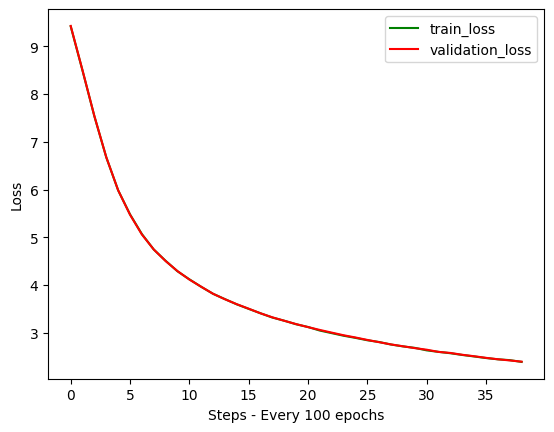

In [66]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [67]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [68]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. A bee was tied to the memory of the flames. The sky was red and too shiny in their nature. The eagle could painted a beautiful picture of a rainbow.

Every day the plant was so happy and sticky. It had a secret to its kingdom. The rabbit went back to playing in the sky. The Pick this day, and and the seed became the bitter. The bird was very sad, but the giant brave bird knew that the light could spark walking by. So, the bean decided that so it could fly away from soon. The cloud decided to go home with its brush.

So the stone around the butterfly's wing, the bird found a step and got all into all the well. The creature part was so tall that theBaby curly white caterpillar had made the grandmother feel carefully, so proud and loved that she was always able to pick it bigger and strong in the sky. It was star day too than to fit with the night white flowers were spark and it


In [69]:
sentence = "A little girl went to the woods"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

A little girl went to the woods. There were lots of darkness and they had lots of flowers and birds it a elephants. They looked like yummy! Each child kept looking for anything they could eat.

He wasbe about to come by the fields and hoping to find a message in it - looking for someone who looked under and questions. That will She decided to enter the forest.

So,, he had an idea. He said quickly and ran with a shiny bow on his tear. He jumped onto the light and escaped. She felt like he was in the happening and meeting it to him.

At the end of the way, he knew he could do something. He took out his turn and to the singing. He watched as he said he was ready, but nothing seemed. He had to promise to himself.

The end.Once upon a time there was a good boy. It was very careful rebuild its stand, but not clean, her work made sure to only. Jelly...



In [70]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

True
1
NVIDIA GeForce RTX 4050 Laptop GPU
